In [1]:
from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import util

Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


In [2]:
clobber = False

In [3]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
try:
    cluster
    client
except:
    cluster = NCARCluster()
    cluster.scale(35)
    client = Client(cluster) # Connect this local process to remote workers
client

/glade/work/mclong/miniconda3/envs/krill/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://10.12.205.30:40412 Dashboard: https://jupyterhub.ucar.edu/dav/user/mclong/proxy/41235/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## compute retrospective trends 

In [4]:
%%time
name = 'cesm-le-fields-djf-retro-trends'
@xp.persist_ds(name=name, format='zarr', path=util.project_tmpdir, trust_cache=True, clobber=clobber)
def retro_trends():

    ds_djf = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf.zarr') 
    
    # set up trend dimensions
    trend_year = xr.DataArray(np.arange(2000, 2101, 1), dims=('time'))
    trend_length = xr.DataArray([5, 10, 20, 60], dims=('trend_length'))

    # loop over trends
    ds_list = []
    for end_year, n_year in product(trend_year.values, trend_length.values):

        # subset data for the time-period of this trend
        ds = ds_djf.sel(time=slice(end_year-n_year+1, end_year))
        if len(ds.time) != n_year: 
            continue

        # loop over vars and compute trends
        da_list = []
        for v in ds.data_vars:
            da = util.linear_trend(
                ds[v]
            ).expand_dims(
                trend_length=[n_year], 
                trend_year=[end_year]
            ) * 10.
            da.attrs = ds[v].attrs
            da.attrs['units'] = ds[v].units + ' decade$^{-1}$'
            da_list.append(da)
            
        ds_list.append(xr.merge(da_list))

    return xr.combine_by_coords(ds_list) #.compute()

ds = retro_trends()
ds

assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/krill-cesm-le/data/cesm-le-fields-djf-retro-trends.zarr
CPU times: user 141 ms, sys: 39.9 ms, total: 180 ms
Wall time: 569 ms


<xarray.Dataset>
Dimensions:       (length: 3, member_id: 34, nlat: 93, nlon: 320, trend_length: 4, trend_year: 101)
Coordinates:
    KMT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA         (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG         (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG         (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * length        (length) float64 20.0 40.0 60.0
  * member_id     (member_id) int64 1 2 9 10 11 12 13 ... 35 101 102 103 104 105
  * trend_length  (trend_length) int64 5 10 20 60
  * trend_year    (trend_year) int64 2000 2001 2002 2003 ... 2097 2098 2099 2100
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf      (trend_length, trend_year, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 1, 93, 320), meta=np.ndarray>
    IFRAC         (trend_length, trend_year, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 1, 93, 320), meta=np.ndarray>
    KGP           (trend_length, trend_year, length, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 3, 1, 93, 320), meta=np.ndarray>
    SST           (trend_length, trend_year, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 1, 93, 320), meta=np.ndarray>

In [5]:
%%time
name = 'cesm-le-fields-djf-prospective-trends'
@xp.persist_ds(name=name, format='zarr', path=util.project_tmpdir, trust_cache=True, clobber=clobber)
def prospective_trends():

    ds_djf = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf.zarr') 
    
    # set up trend dimensions
    trend_year = xr.DataArray([2006, 2020,], dims=('time'))
    trend_length = xr.DataArray([5, 10, 20, 50], dims=('trend_length'))

    # loop over trends
    ds_list = []
    for start_year, n_year in product(trend_year.values, trend_length.values):

        # subset data for the time-period of this trend
        ds = ds_djf.sel(time=slice(start_year, start_year+n_year-1))
        if len(ds.time) != n_year: 
            continue

        # loop over vars and compute trends
        da_list = []
        for v in ds.data_vars:
            da = util.linear_trend(
                ds[v]
            ).expand_dims(
                trend_length=[n_year], 
                trend_year=[start_year]
            ) * 10.
            da.attrs = ds[v].attrs
            da.attrs['units'] = ds[v].units + ' decade$^{-1}$'
            da_list.append(da)
            
        ds_list.append(xr.merge(da_list))

    return xr.combine_by_coords(ds_list) #.compute()

ds = prospective_trends()
ds

writing cache file: /glade/p/cgd/oce/projects/krill-cesm-le/data/cesm-le-fields-djf-prospective-trends.zarr
CPU times: user 30.1 s, sys: 2.47 s, total: 32.5 s
Wall time: 9min 9s


<xarray.Dataset>
Dimensions:       (length: 3, member_id: 34, nlat: 93, nlon: 320, trend_length: 4, trend_year: 2)
Coordinates:
    TLAT          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA         (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG         (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG         (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    KMT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * member_id     (member_id) int64 1 2 9 10 11 12 13 ... 35 101 102 103 104 105
  * length        (length) float64 20.0 40.0 60.0
  * trend_length  (trend_length) int64 5 10 20 50
  * trend_year    (trend_year) int64 2006 2020
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf      (trend_length, trend_year, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 1, 93, 320), meta=np.ndarray>
    IFRAC         (trend_length, trend_year, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 1, 93, 320), meta=np.ndarray>
    KGP           (trend_length, trend_year, length, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 3, 1, 93, 320), meta=np.ndarray>
    SST           (trend_length, trend_year, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 1, 93, 320), meta=np.ndarray>

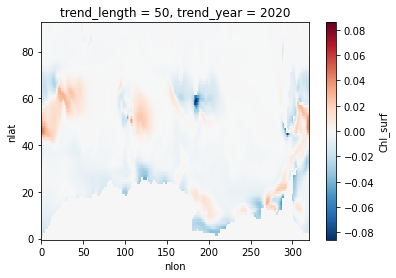

In [10]:
ds.Chl_surf.sel(trend_year=2020, trend_length=50).mean('member_id').plot()

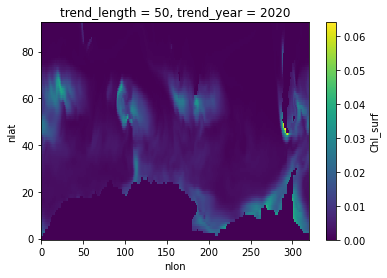

In [11]:
ds.Chl_surf.sel(trend_year=2020, trend_length=50).std('member_id').plot()